In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
TOTAL_ROWS = 10000

COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current',
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

INPUT_COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current'
]

OUTPUT_COLUMNS = [
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

CATEGORICAL_LABELS = ['leaking', 'explosion']
REGRESSION_LABELS = ['leak rate', 'explosive force']

In [5]:
def generate_coefficients(input_length, output_length):
    mean = 0
    stddev = 5.0
    rows = input_length
    columns = output_length
    return np.random.normal(mean, stddev, size=(rows, columns))

def generate_row(coefficients):
    rows, columns = coefficients.shape
    input_row = np.random.rand(columns)
    output = np.matmul(coefficients, input_row)
    output = output.tolist()
    assert len(output) >= 4
    output[-2] = "leaking" if output[-4] > 0 else "not leaking"
    output[-1] = "explosion" if output[-3] > 0 else "no explosion"
    output = input_row.tolist() + output
    return output

def generate_sets(myset, output_columns, categorical_labels):
    myset_labels = myset[output_columns].copy()
    myset = myset.drop(output_columns, axis=1)
    myset_categorical = myset_labels[categorical_labels]
    myset_labels.drop(categorical_labels, axis=1)
    categorical_encoder = OneHotEncoder(sparse_output=False)
    myset_categorical = categorical_encoder.fit_transform(myset_categorical)
    return myset, myset_labels, myset_categorical, categorical_encoder

In [6]:
my_dataframe = pd.DataFrame(columns=COLUMNS)
coefficients = generate_coefficients(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))
for i in range(TOTAL_ROWS):
    my_dataframe.loc[len(my_dataframe)] = generate_row(coefficients)
print(my_dataframe.head())

   electrode force  electrode contact surface diameter  squeeze time  \
0         0.868532                            0.851671      0.758218   
1         0.279985                            0.334890      0.535683   
2         0.172211                            0.446364      0.486299   
3         0.386395                            0.265596      0.589903   
4         0.971657                            0.272425      0.217422   

   weld time  hold time  weld current  leak rate  explosive force  \
0   0.256115   2.513977     22.226443  -6.271782       -18.181455   
1   0.374953   1.202295     11.884132  -4.725227        -7.015464   
2   0.189616   0.451185     10.892596  -3.773565        -6.331197   
3   0.946366   2.861346     14.119183  -7.051818        -8.031213   
4   0.578170   4.240190     12.810629  -4.094655       -14.202506   

       leaking     explosion  
0  not leaking  no explosion  
1  not leaking  no explosion  
2  not leaking  no explosion  
3  not leaking  no explosion

In [7]:
X_train, X_test = train_test_split(my_dataframe, test_size=0.2, random_state=42)
X_train, X_validation = train_test_split(X_train)

X_train_labels = X_train[OUTPUT_COLUMNS].copy()
X_train = X_train.drop(OUTPUT_COLUMNS, axis=1)
X_train_categorical = X_train_labels[CATEGORICAL_LABELS]
X_train_labels = X_train_labels.drop(CATEGORICAL_LABELS, axis=1)
train_categorical_encoder = OneHotEncoder(sparse_output=False)
X_train_categorical = train_categorical_encoder.fit_transform(X_train_categorical)

X_test_labels = X_test[OUTPUT_COLUMNS].copy()
X_test = X_test.drop(OUTPUT_COLUMNS, axis=1)
X_test_categorical = X_test_labels[CATEGORICAL_LABELS]
X_test_labels = X_test_labels.drop(CATEGORICAL_LABELS, axis=1)
test_categorical_encoder = OneHotEncoder(sparse_output=False)
X_test_categorical = test_categorical_encoder.fit_transform(X_test_categorical)

X_validation_labels = X_validation[OUTPUT_COLUMNS].copy()
X_validation = X_validation.drop(OUTPUT_COLUMNS, axis=1)
X_validation_categorical = X_validation_labels[CATEGORICAL_LABELS]
X_validation_labels = X_validation_labels.drop(CATEGORICAL_LABELS, axis=1)
validation_categorical_encoder = OneHotEncoder(sparse_output=False)
X_validation_categorical = validation_categorical_encoder.fit_transform(X_validation_categorical)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

print(X_train_categorical[:10])
print(train_categorical_encoder.categories_)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[array(['not leaking'], dtype=object), array(['no explosion'], dtype=object)]


In [11]:
y_train_regression = X_train_labels
y_train_classification = X_train_categorical
y_test_regression = X_test_labels
y_test_classification = X_test_categorical
y_validation_regression = X_validation_labels
y_validation_classification = X_validation_categorical

In [12]:
import tensorflow as tf
from tensorflow import keras

In [15]:
INPUT_WIDTH = len(INPUT_COLUMNS)
OUTPUT_WIDTH = len(OUTPUT_COLUMNS)
CLASSIFICATION_LABELS = CATEGORICAL_LABELS

In [16]:
inputs = keras.Input(shape=(INPUT_WIDTH,), name="input")
x = keras.layers.Dense(INPUT_WIDTH * 10, activation="relu")(inputs)
x = keras.layers.Dense(INPUT_WIDTH * 5, activation="relu")(x)
regression_output = keras.layers.Dense(len(REGRESSION_LABELS), name="regression")(x)
classification_output = keras.layers.Dense(
    len(CLASSIFICATION_LABELS),
    activation="sigmoid",
    name="classification")(x)
model = keras.Model(
    inputs=inputs,
    outputs=[regression_output, classification_output],
    name="multi_output_model")
model.compile(
    loss={"regression": "mse", "classification": "categorical_crossentropy"},
    optimizer="adam",
    metrics={"regression": ["mae"], "classification": ["accuracy"]})
history = model.fit(
    X_train,
    {"regression": y_train_regression, "classification": y_train_classification},
    validation_data=(X_validation, {"regression": y_validation_regression, "classification": y_validation_classification}),
    epochs=30)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - classification_accuracy: 0.0479 - classification_loss: 2.1999 - loss: 50.7271 - regression_loss: 48.5266 - regression_mae: 5.7181 - val_classification_accuracy: 0.0000e+00 - val_classification_loss: 2.6133 - val_loss: 5.4961 - val_regression_loss: 2.8834 - val_regression_mae: 1.3299
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_accuracy: 0.0000e+00 - classification_loss: 2.4391 - loss: 4.7120 - regression_loss: 2.2729 - regression_mae: 1.1555 - val_classification_accuracy: 0.0000e+00 - val_classification_loss: 2.6775 - val_loss: 4.2103 - val_regression_loss: 1.5306 - val_regression_mae: 0.9384
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_accuracy: 0.0020 - classification_loss: 2.8171 - loss: 4.4079 - regression_loss: 1.5908 - regression_mae: 0.9656 - val_classification_accuracy: 0.0085 - val_classification_loss: 3.1115 - val_loss: 4.9646 - val_regression_loss: 1.8468 - val_regression_ma

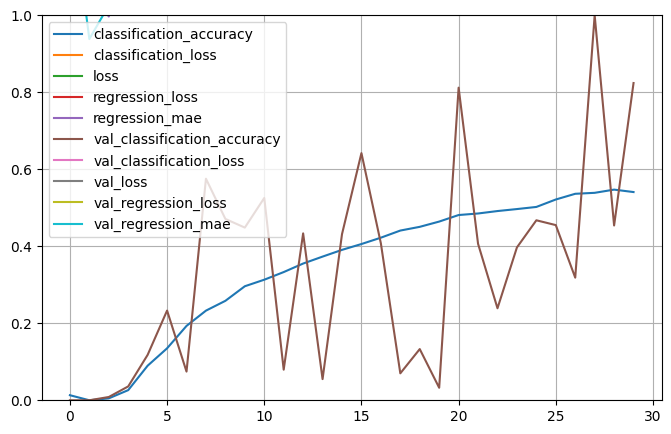

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
y_predictions_regression, y_predictions_classification = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
